In [23]:
import gurobipy as gp
from gurobipy import GRB

import pandas as pd
import numpy as np

#########################################################
# Constants
#########################################################

C = np.array(
    [13.32, 13.32, 20.7, 20.93, 26.11, 10.52, 10.52, 6.02, 5.47, 0, 10.52, 10.89]
    + [0] * 6
)

wind = pd.read_csv("windData.csv", index_col="hour")
wind = wind[["V1", "V2", "V3", "V4", "V5", "V6"]].iloc[0].to_numpy() * 200
P_MAX = np.array(
    [152, 152, 350, 591, 60, 155, 155, 400, 400, 300, 310, 350] + wind.tolist()
)

D = 1500*4
bid_price = np.array([12,14,18])

#########################################################
# Model
#########################################################

# Create a new model
m = gp.Model("Copper-plate single hour")

# Create variables
p = m.addMVar(
    shape=(12 + 6,), lb=0, ub=P_MAX, name="Power generation", vtype=GRB.CONTINUOUS
)
d = m.addMVar(
    shape=(3,), lb=0, ub=[0.5*D,0.2*D,0.3*D], name = "Demand", vtype=GRB.CONTINUOUS
)

# Set objective: maximize
objective = m.setObjective(sum(bid_price[i]*d[i] for i in range(3)) - sum(C[i] * p[i] for i in range(12 + 6)), GRB.MAXIMIZE)

# Constraint: D - sum(p) = 0
balance = m.addConstr(-sum(p[i] for i in range(12 + 6)) + sum(d[i] for i in range(3)) == 0, "Generation balance")

# Optimize model
m.optimize()

#########################################################
# Some prints
#########################################################

price = m.getAttr("Pi", m.getConstrs())[0]
print(f"Market-clearing price: {price}")
print("Generation units :")
for j in range(12 + 6):
    print(
        f"    Generation unit {j+1} produces: {round(p.X[j],2)} - Profit: {round(p.X[j]*price,2)}"
    )
print(f"Social welfare is: {D*price - m.getObjective().getValue()}")

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x0f0cb52f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+01]
  Bounds range     [6e+01, 3e+03]
  RHS range        [0e+00, 0e+00]
Presolve removed 0 rows and 9 columns
Presolve time: 0.02s
Presolved: 1 rows, 12 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    8.5200000e+04   6.467956e+02   0.000000e+00      0s
       1    2.8815711e+04   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.03 seconds (0.00 work units)
Optimal objective  2.881571136e+04
Market-clearing price: 14.0
Generation units :
    Generation unit 1 produces: 152.0 - Profit: 2128.0
    Generation unit 2 produces: 152.0 - Pr

Market clearing price: 14.0


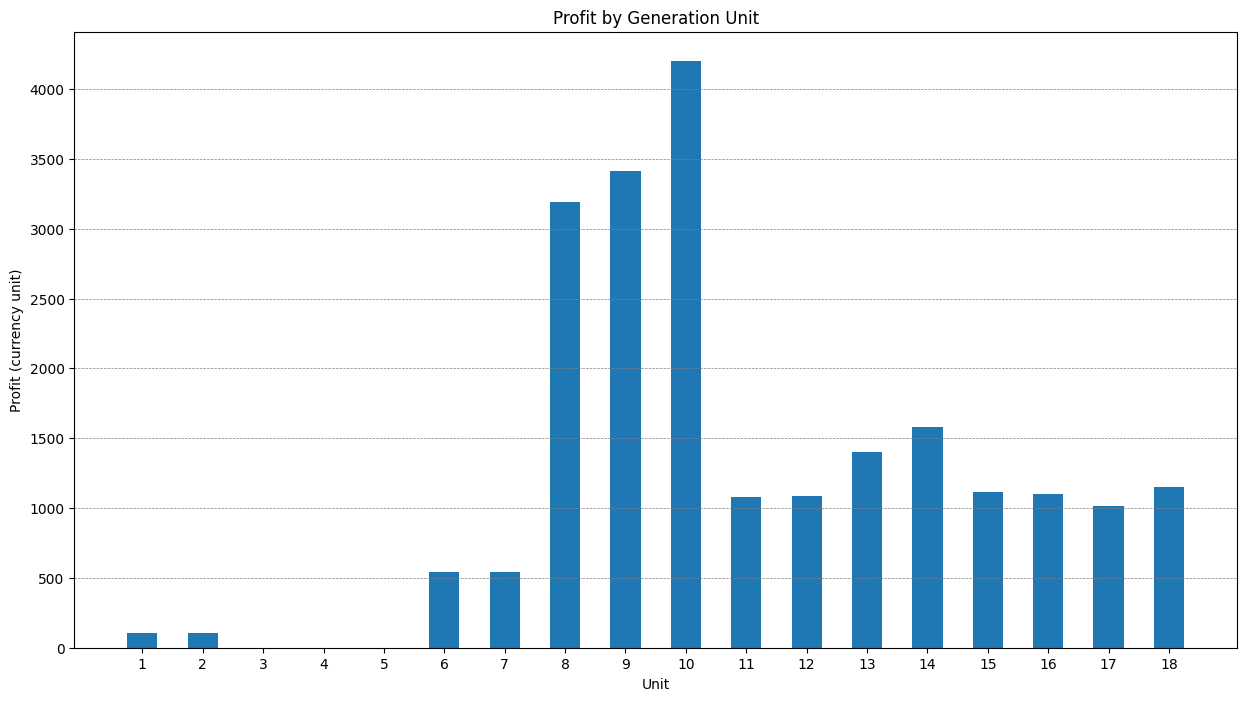

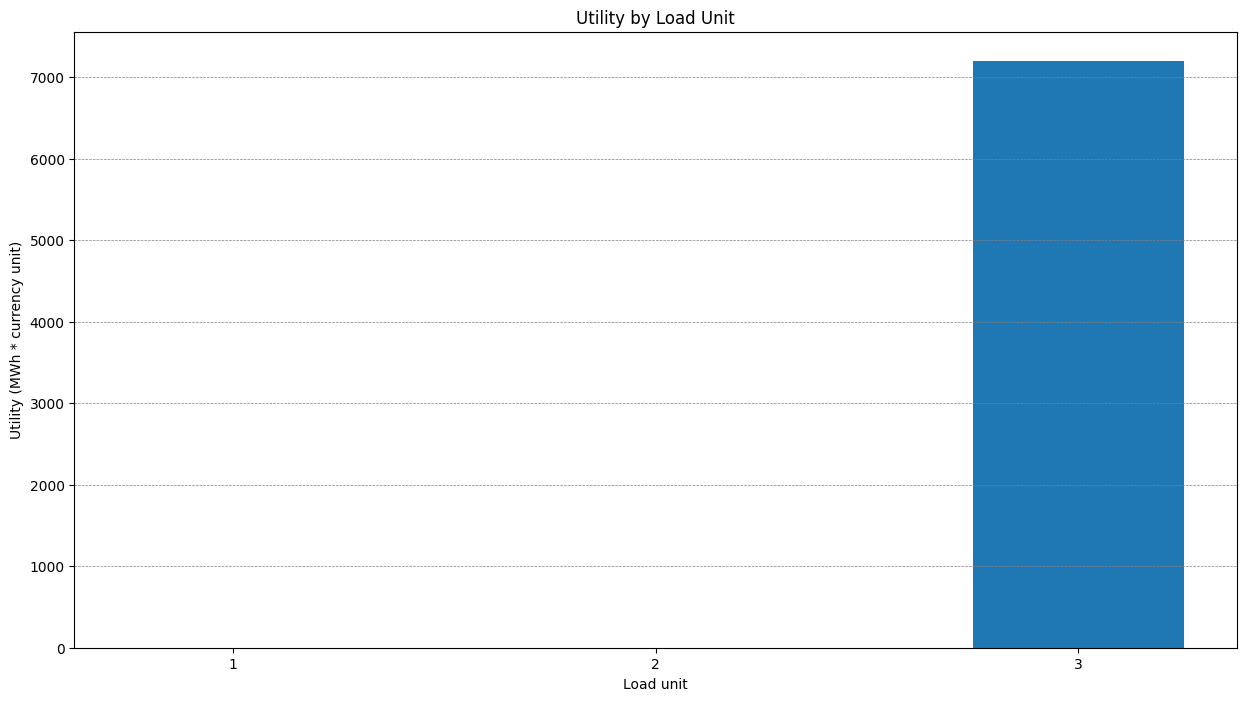

In [24]:

import matplotlib.pyplot as plt

generation_units = [f"{j+1}" for j in range(12 + 6)]
load_units = [f"{j+1}" for j in range(3)]
production = np.array([round(p.X[j], 2) for j in range(12 + 6)])
demand = np.array([round(d.X[j], 2) for j in range(3)])
revenue = np.array([round(p.X[j] * price, 2) for j in range(12 + 6)])
profit = revenue - production * C

print(f"Market clearing price: {price}")

plt.figure(figsize=(15,8))
plt.bar(generation_units, profit, width=0.5)
plt.ylabel("Profit (currency unit)")
plt.xlabel("Unit")
plt.title("Profit by Generation Unit")
plt.grid(axis="y", which='major', linestyle="--", linewidth=0.5, color="gray")

plt.show()

plt.figure(figsize=(15,8))
plt.bar(load_units, demand * (bid_price - price), width=0.5)
plt.ylabel("Utility (MWh * currency unit)")
plt.xlabel("Load unit")
plt.title("Utility by Load Unit")
plt.grid(axis="y", which='major', linestyle="--", linewidth=0.5, color="gray")

plt.show()


In [25]:
from meritOrderCurve import *

Production ... 
 Costs:      [ 0.    0.    0.    0.    0.    0.    0.    5.47  6.02 10.52 10.52 10.52
 10.89 13.32 13.32 20.7  20.93 26.11] 
 Production: [  82.44  161.12  240.5   353.31  453.14  753.14  825.64 1225.64 1625.64
 1780.64 1935.64 2245.64 2595.64 2747.64 2899.64 2899.64 2899.64 2899.64] 
 
Demand ... 
 Costs:  [18 14 12] 
 Demand: [1800.   2899.64 2899.64] 



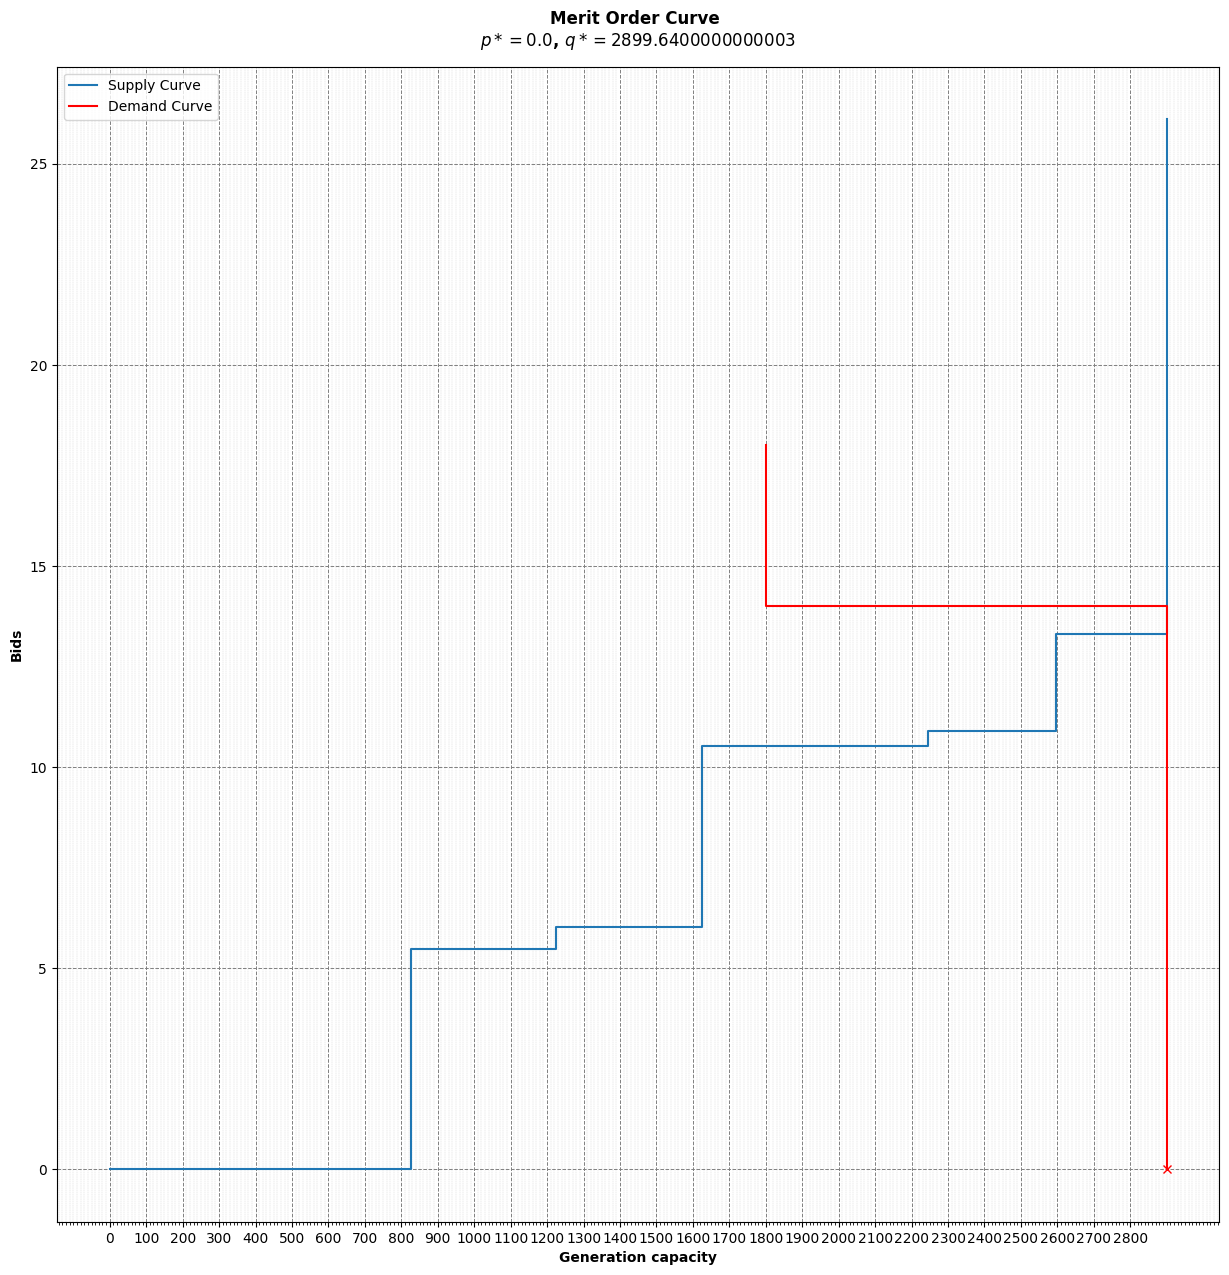

In [26]:
curve = MeritOrderCurve(
    productions=production,
    prod_marginal_costs=C,
    demands=demand,
    demands_marginal_costs=bid_price
)

curve.merit_order_curve()